In [1]:
# https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
from collections import defaultdict
%config InlineBacked.figure_format = 'retina'
SEED = [20100420, 20100234]

print('Running on PyMC3 v{}'.format(pm.__version__))

/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Running on PyMC3 v3.5


### Eight schools model

In [2]:
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.

### A centered eight schools implementation
- pathological geometry that frustrates geometric ergodicity
- resulting subtle bias

In [3]:
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sd=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sd=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sd=sigma, observed=y)

### A dangerously short Markov chain

In [4]:
with Centered_eight:
    short_trace = pm.sample(600, chains=2, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]
Sampling 2 chains: 100%|██████████| 2200/2200 [00:05<00:00, 411.88draws/s]
There were 63 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.611427326021, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [5]:
pm.summary(short_trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu,4.92,2.98,0.17,-1.67,10.30,255.15,1.00
theta__0,6.78,5.20,0.28,-2.61,17.04,137.14,1.03
theta__1,5.34,4.42,0.18,-4.01,14.72,524.36,1.00
theta__2,4.45,4.75,0.20,-5.36,13.23,445.37,1.00
theta__3,5.36,4.69,0.21,-3.58,15.70,415.04,1.00
theta__4,4.12,4.38,0.18,-5.63,12.36,418.62,1.00
theta__5,4.57,4.41,0.19,-5.01,12.71,413.21,1.00
theta__6,6.77,4.67,0.24,-1.59,17.06,203.87,1.01
theta__7,5.52,5.23,0.20,-5.55,15.22,500.04,1.00
tau,3.69,3.09,0.22,0.55,9.55,26.74,1.07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b587828>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c1bedd860>]], dtype=object)

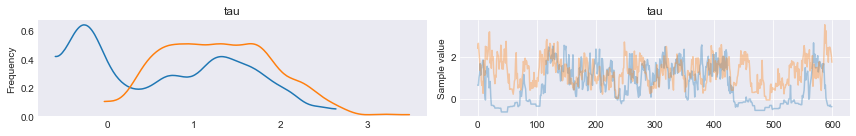

In [6]:
pm.traceplot(short_trace, varnames=['tau'], transform=np.log)

Text(0.5,1,'MCMC estimation of log(tau)')

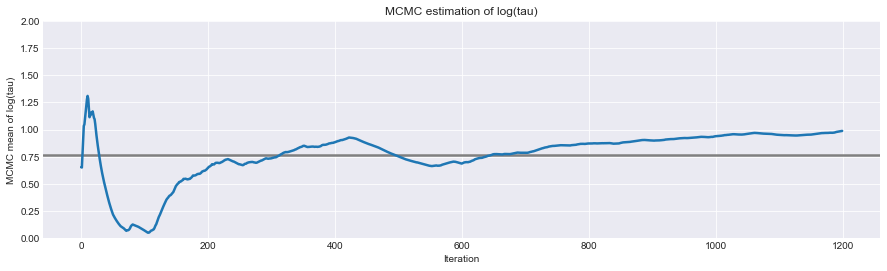

In [8]:
logtau = np.log(short_trace['tau'])
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]

plt.figure(figsize=(15, 4))
plt.axhline(0.7657852, lw=2.5, color='gray')
plt.plot(mlogtau, lw=2.5)
plt.ylim(0, 2)
plt.xlabel('Iteration')
plt.ylabel('MCMC mean of log(tau)')
plt.title('MCMC estimation of log(tau)')

In [11]:
divergent = short_trace['diverging']
print('Number of divergent {}'.format(divergent.nonzero()[0].size))

divperc = divergent.nonzero()[0].size / len(short_trace) * 100
print('Percentage of Divergent {} %'.format(divperc))

Number of divergent 68
Percentage of Divergent 11.333333333333332 %


Text(0.5,1,'scatter plot between log(tau) and theta[0]')

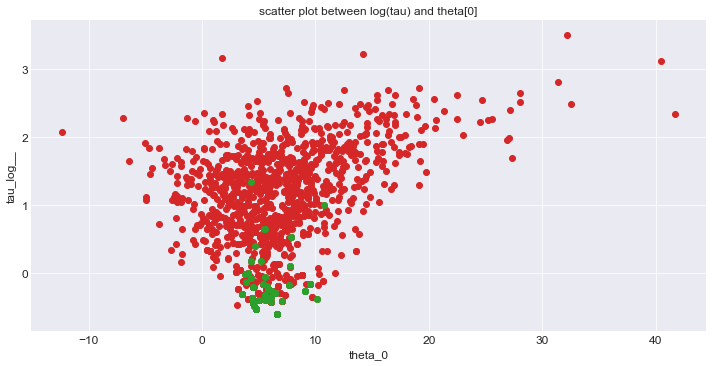

In [12]:
pm.pairplot(short_trace,
           sub_varnames=['theta_0', 'tau_log__'],
           divergences=True,
           color='C3', figsize=(10, 5),
           kwargs_divergence={'color': 'C2'})
plt.title('scatter plot between log(tau) and theta[0]')

In [19]:
divergent_point = defaultdict(list)

chain_warn = short_trace.report._chain_warnings
for i in range(len(chain_warn)):
    for warning_ in chain_warn[i]:
        if warning_.step is not None and warning_.extra is not None:
            for RV in Centered_eight.free_RVs:
                para_name = RV.name
                divergent_point[para_name].append(warning_.extra[para_name])
for RV in Centered_eight.free_RVs:
    para_name = RV.name
    divergent_point[para_name] = np.asarray(divergent_point[para_name])
ii = 5

tau_log_d = divergent_point['tau_log__']
theta0_d = divergent_point['theta'][:, ii]
Ndiv_recorded = len(tau_log_d)

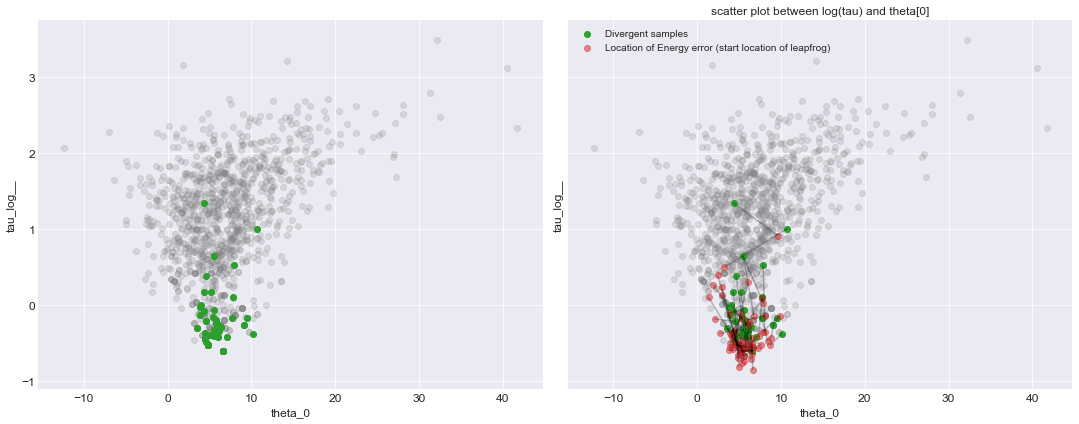

In [20]:
_, ax = plt.subplots(1, 2, figsize=(15, 6), 
                     sharex=True, sharey=True)

pm.pairplot(short_trace, 
           sub_varnames=['theta_0', 'tau_log__'],
           divergences=True,
           ax=ax[0],
           color='C7',
           figsize=(12, 10),
           alpha=0.2,
           kwargs_divergence={'color': 'C2'})

plt.title('scatter plot between log(tau) and theta[5]')

pm.pairplot(short_trace,
               sub_varnames=['theta_0', 'tau_log__'],
               divergences=True,
               ax=ax[1],
               color='C7', alpha=0.2, figsize=(12, 10),
               kwargs_divergence={'color':'C2', 'label':'Divergent samples'})

theta_trace = short_trace['theta']
theta0 = theta_trace[:, 0]

plt.plot([theta0[divergent == 1][:Ndiv_recorded], theta0_d],
           [logtau[divergent == 1][:Ndiv_recorded], tau_log_d],
           'k-', alpha=.25)

plt.scatter(theta0_d, tau_log_d,
              color='C3', alpha=.5, label='Location of Energy error (start location of leapfrog)')

plt.title('scatter plot between log(tau) and theta[0]')
plt.legend();

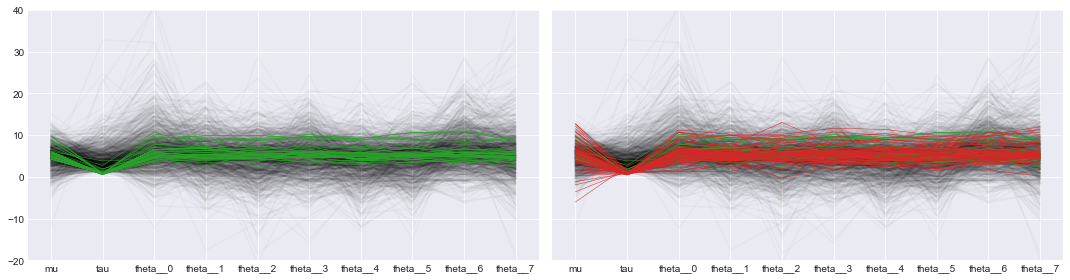

In [22]:
tracedf = pm.trace_to_dataframe(short_trace)
plotorder = ['mu', 'tau', 'theta__0', 'theta__1', 'theta__2', 'theta__3', 'theta__4',
             'theta__5', 'theta__6', 'theta__7']
tracedf = tracedf[plotorder]

_, ax = plt.subplots(1, 2, figsize=(15, 4), sharex=True, sharey=True)
ax[0].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[0].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)

ax[1].plot(tracedf.values[divergent == 0].T, color='k', alpha=.025)
ax[1].plot(tracedf.values[divergent == 1].T, color='C2', lw=.5)
divsp = np.hstack([divergent_point['mu'][:,None],
                   np.exp(divergent_point['tau_log__'])[:,None],
                   divergent_point['theta']])
ax[1].plot(divsp.T, 'C3', lw=.5)
plt.ylim([-20,40])
plt.xticks(range(10), plotorder)
plt.tight_layout();